# RNNs Aren't *that* Mysterious

In this, the final notebook of part I of the fast.ai course, we look at how RNNs, or recurrent neural networks, work. We'll see that unlike a GAN, for example, RNNs actually aren't so different from a standard multi-layer perceptron, or deep neural network. It turns out that there are only a few modifications that make RNNs unique, but these simple tweaks enable the network to do a much better job of understanding and predicting how sequences change over time

In [4]:
from fastai import *
from fastai.text import *

In [5]:
# Get nicer looking graphs for retina displays
%config InlineBackend.figure_format = 'retina'

## Getting the Dataset

We'll use a very simple dataset to compare how deep neural networks, RNNs, and finally RNNs with memory compare in their ability to predict a sequence. 

Our dataset is simply the numbers one through nine-thousand nine-hundred ninety-nine, written out in text. The best performing network will obviously be the one that most often predicts the right numerical words in the right order.

In [6]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/human_numbers/valid.txt'),
 PosixPath('/home/jupyter/.fastai/data/human_numbers/train.txt'),
 PosixPath('/home/jupyter/.fastai/data/human_numbers/models')]

A short method to read the numbers from the train/valid text files.

In [7]:
def readnums(d):
    return [', '.join(o.strip() for o in open(path/d).readlines())]

In [8]:
train_txt = readnums('train.txt')
train_txt[0][:83]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirteen'

In [9]:
train_txt[0][-81:]

'seven thousand nine hundred ninety eight, seven thousand nine hundred ninety nine'

In [10]:
valid_txt = readnums('valid.txt')
valid_txt[0][:81]

'eight thousand one, eight thousand two, eight thousand three, eight thousand four'

In [11]:
valid_txt[0][-79:]

'nine thousand nine hundred ninety eight, nine thousand nine hundred ninety nine'

We see that the training set contains numbers 1 through 7,999, and the validation set contains numbers 8,000 through 9,999. 

The best algorithm will be able to most accurately write out all the numbers in the validation set in plain text and in the right order.

## Preparing the Data for Training

We'll wrap both the train and valid sets as `TextList()` objects and place both inside a data bunch.

In [12]:
bs = 64

In [13]:
train = TextList(train_txt, path=path)
valid = TextList(valid_txt, path=path)

src = ItemLists(path=path, train=train, valid=valid).label_for_lm()
data = src.databunch(bs=bs)

We'll run some quick sanity checks to verify that our data is stored, and that batches are generated, in the manner we expect.

In [14]:
data.train_ds[0][0].text[:81]

'xxbos one , two , three , four , five , six , seven , eight , nine , ten , eleven'

In [15]:
data.train_ds[0][0].data

array([ 2, 11,  8, 12, ..., 19,  9, 27, 19])

Notice how the fastai library automatically tokenizes our text data's vocabulary for us.

In [16]:
len(data.train_ds[0][0].data)

50079

In [17]:
data.valid_ds[0][0].text[:90]

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four'

In [18]:
data.valid_ds[0][0].text[-80:]

'nine thousand nine hundred ninety eight , nine thousand nine hundred ninety nine'

In [19]:
data.valid_ds[0][0].data

array([ 2, 18, 10, 11, ..., 19,  9, 27, 19])

In [20]:
valid_len = len(data.valid_ds[0][0].data); valid_len

13017

We'll use the fastai default sequence length of 70. This means that the previous 70 words are used to predict each subsequent word. The `bptt`, or back propagation through time, parameter is used to specify this.

When calculating sequence length for each batch, fastai slightly, randomly perturbs this value such that sequence length varies from batch to batch.

In [21]:
data.bptt

70

With a batch size of 64 and sequence length of 70, it will take three iterations to predict each word in the validation set.

In [22]:
valid_len/data.bptt/bs

2.905580357142857

Let's see what these three iterarions through the validation set would look like.

In [23]:
it = iter(data.valid_dl)
x1,y1 = next(it)
x2,y2 = next(it)
x3,y3 = next(it)
it.close()

In [24]:
x1.numel(), x2.numel(), x3.numel()

(6080, 5056, 1792)

In [25]:
x1.numel() + x2.numel() + x3.numel()

12928

In [26]:
x1.shape, y1.shape

(torch.Size([95, 64]), torch.Size([95, 64]))

In [27]:
x2.shape, y2.shape

(torch.Size([79, 64]), torch.Size([79, 64]))

In [28]:
x3.shape, y3.shape

(torch.Size([28, 64]), torch.Size([28, 64]))

In [29]:
x1[:,0]

tensor([ 2, 18, 10, 11,  8, 18, 10, 12,  8, 18, 10, 13,  8, 18, 10, 14,  8, 18,
        10, 15,  8, 18, 10, 16,  8, 18, 10, 17,  8, 18, 10, 18,  8, 18, 10, 19,
         8, 18, 10, 28,  8, 18, 10, 29,  8, 18, 10, 30,  8, 18, 10, 31,  8, 18,
        10, 32,  8, 18, 10, 33,  8, 18, 10, 34,  8, 18, 10, 35,  8, 18, 10, 36,
         8, 18, 10, 37,  8, 18, 10, 20,  8, 18, 10, 20, 11,  8, 18, 10, 20, 12,
         8, 18, 10, 20, 13], device='cuda:0')

In [30]:
y1[:,0]

tensor([18, 10, 11,  8, 18, 10, 12,  8, 18, 10, 13,  8, 18, 10, 14,  8, 18, 10,
        15,  8, 18, 10, 16,  8, 18, 10, 17,  8, 18, 10, 18,  8, 18, 10, 19,  8,
        18, 10, 28,  8, 18, 10, 29,  8, 18, 10, 30,  8, 18, 10, 31,  8, 18, 10,
        32,  8, 18, 10, 33,  8, 18, 10, 34,  8, 18, 10, 35,  8, 18, 10, 36,  8,
        18, 10, 37,  8, 18, 10, 20,  8, 18, 10, 20, 11,  8, 18, 10, 20, 12,  8,
        18, 10, 20, 13,  8], device='cuda:0')

Notice how the values of labels, the columns in `y1`, are nearly identical to each corresponding column of the inputs, `x1`, but offset by one position. This is because for each word, the model is trying to correctly predict the next word in the sequence.

Notice also how each batch contains 64 sequences in columns (not the rows!) that contain consecutive numbers written as text. 

Finally, also notice that the lengths of the sequences in each batch vary from one iteration to the next.

In [31]:
v = data.valid_ds.vocab

In [32]:
v.textify(x1[:,0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand eighteen , eight thousand nineteen , eight thousand twenty , eight thousand twenty one , eight thousand twenty two , eight thousand twenty three'

In [33]:
v.textify(x2[:,0])

', eight thousand twenty four , eight thousand twenty five , eight thousand twenty six , eight thousand twenty seven , eight thousand twenty eight , eight thousand twenty nine , eight thousand thirty , eight thousand thirty one , eight thousand thirty two , eight thousand thirty three , eight thousand thirty four , eight thousand thirty five , eight thousand thirty six , eight thousand thirty seven , eight thousand thirty eight , eight thousand thirty nine'

In [34]:
v.textify(x3[:,0])

', eight thousand forty , eight thousand forty one , eight thousand forty two , eight thousand forty three , eight thousand forty four , eight thousand forty'

In [35]:
v.textify(x1[:,1])

', eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight thousand sixty , eight thousand sixty one , eight thousand sixty two , eight thousand sixty three , eight thousand sixty four , eight'

In [36]:
v.textify(x2[:,1])

'thousand sixty five , eight thousand sixty six , eight thousand sixty seven , eight thousand sixty eight , eight thousand sixty nine , eight thousand seventy , eight thousand seventy one , eight thousand seventy two , eight thousand seventy three , eight thousand seventy four , eight thousand seventy five , eight thousand seventy six , eight thousand seventy seven , eight thousand seventy eight , eight thousand seventy nine , eight thousand eighty , eight thousand'

In [37]:
v.textify(x3[:,1])

'eighty one , eight thousand eighty two , eight thousand eighty three , eight thousand eighty four , eight thousand eighty five , eight thousand eighty six ,'

Also important to observe: the columns, or text sequences in each batch are not themselves sequential. The data is loaded such that the first column in the first batch directly precedes the first column of the second batch, which itself directly precedes the first column of the third batch. 

Notice that there are a small amount of words in the validation set that we don't make predictions for. For example, observe above that there is a bit of a gap between the end of the first sequence of the third batch:
```
..., eight thousand forty two , eight thousand forty three , eight
```
and the second sequence of the first batch:
```
..., eight thousand forty six , eight thousand forty seven ,
```
What happened to the missing text, why was it omitted? Well, fastai has a [SortishSampler()](https://github.com/fastai/fastai/blob/21bfa52385d684df758dbe748098c66f1e8cbd3e/fastai/text/data.py) class that adds a bit of randomness into how it samples data from the dataset. I believe this is why we see the gap described just above, as well as why our final batch doesn't quite predict the last few words of the validation set, but instead stops here:

```
nine thousand nine hundred ninety four , nine thousand nine hundred ninety five , nine
```

Additionally, why is the data staggered in between batches the way it is? Doesn't it make sense to have each sequence, or column, in the first batch contain consecutive rows of text, and so on and so forth for the rest of the batches? In other words, How come the first batch doesn't handle the first third of the validation set's text, followed by the second batch handling the second third, and finally the third and final batch containing the last third of the validation text?

Well, if we're only training on only one GPU, the data loader's approach does seem pretty counter-intuitive. If we only have one GPU we obviously train each batch *sequentially* and having each batch contain text snippets from the first, second, and third parts of the validation set seems like it makes things unnecessarily confusing.

However, what if we had three GPUs? This would mean that we could train all three batches *simultaneously*. If this were the case, it becomes much clearer why our data loader works the way it does. We need to be able to potentially load and train all an epoch's batches at the same time. 

This is why our data loader first calculates, given a specific batch size and sequence length (basically, the `bptt` value, but perturbed by a bit of randomness as we'll discuss in a minute), how many iterations (or batches) need to be run such that all, or as much as possible, of the data could be trained at the same time, and such that each batch will be full. The data loader then staggers the data it enters into each batch: the sequences of a given column are perfectly sequential across all batches, however if you take, for example, a super-column 0 that consists of all the sequences in the column at index 0 of each batch, and then super-column 1 that consists of all the sequences in column 1 of each batch, you'll find that there may be a small gap between super-column 0 and super-column 1. (This is what we described just above.) 

One final question remains: if we run the above iterator multiple times, we see that the sequence lengths of the batches fluctuate somewhat randomly. I believe that this is because fastai's [LanguageModelLoader()](https://github.com/fastai/fastai/blob/21bfa52385d684df758dbe748098c66f1e8cbd3e/fastai/text/data.py) class randomly perturbs the `bptt` value for each batch. This is why different batches have different lengths.

In [38]:
v.textify(x1[:,-1])

', nine thousand nine hundred sixty seven , nine thousand nine hundred sixty eight , nine thousand nine hundred sixty nine , nine thousand nine hundred seventy , nine thousand nine hundred seventy one , nine thousand nine hundred seventy two , nine thousand nine hundred seventy three , nine thousand nine hundred seventy four , nine thousand nine hundred seventy five , nine thousand nine hundred seventy six , nine thousand nine hundred seventy seven , nine thousand nine hundred seventy eight , nine thousand nine hundred seventy nine , nine thousand nine hundred'

In [39]:
v.textify(x2[:,-1])

'eighty , nine thousand nine hundred eighty one , nine thousand nine hundred eighty two , nine thousand nine hundred eighty three , nine thousand nine hundred eighty four , nine thousand nine hundred eighty five , nine thousand nine hundred eighty six , nine thousand nine hundred eighty seven , nine thousand nine hundred eighty eight , nine thousand nine hundred eighty nine , nine thousand nine hundred ninety , nine thousand nine hundred ninety one , nine'

In [40]:
v.textify(x3[:,-1])

'thousand nine hundred ninety two , nine thousand nine hundred ninety three , nine thousand nine hundred ninety four , nine thousand nine hundred ninety five , nine'

In [41]:
data.show_batch(ds_type=DatasetType.Valid)

idx,text
0,"xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen ,"
1,", eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight ,"
2,"thousand eighty seven , eight thousand eighty eight , eight thousand eighty nine , eight thousand ninety , eight thousand ninety one , eight thousand ninety two , eight thousand ninety three , eight thousand ninety four , eight thousand ninety five , eight thousand ninety six , eight thousand ninety seven , eight thousand ninety eight , eight thousand ninety nine , eight thousand"
3,"thousand one hundred twenty three , eight thousand one hundred twenty four , eight thousand one hundred twenty five , eight thousand one hundred twenty six , eight thousand one hundred twenty seven , eight thousand one hundred twenty eight , eight thousand one hundred twenty nine , eight thousand one hundred thirty , eight thousand one hundred thirty one , eight thousand one hundred"
4,"fifty two , eight thousand one hundred fifty three , eight thousand one hundred fifty four , eight thousand one hundred fifty five , eight thousand one hundred fifty six , eight thousand one hundred fifty seven , eight thousand one hundred fifty eight , eight thousand one hundred fifty nine , eight thousand one hundred sixty , eight thousand one hundred sixty one ,"


## Training a Single Fully-Connected Model

As a baseline, we'll first train a model that is able to look at a maximum of three previous words and predict the next single word that it thinks should appear in the sequence.

In [114]:
data = src.databunch(bs=bs, bptt=3, max_len=0, p_bptt=1.)

In [115]:
x,y = data.one_batch()
x.shape, y.shape

(torch.Size([3, 64]), torch.Size([3, 64]))

Let's verify the size of our vocabulary in our validation set.

In [116]:
nv = len(v.itos); nv

38

We also need to specify the size of our vocabulary embedding vectors.

In [117]:
nh=64

We'll use a cross entropy loss function.

In [118]:
def loss4(input, target):
    return F.cross_entropy(input, target[-1])

And we'll use accuracy as our metric.

In [119]:
def acc4(input, target):
    return accuracy(input, target[-1])

Here's the single model's architecture.

In [120]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh) # input dim: vocab size x embedding size
        self.h_h = nn.Linear(nh,nh) # hidden layer dim: embedding size x embedding size
        self.h_o = nn.Linear(nh,nv) # output dim: 1 x vocab size
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = self.bn(F.relu(self.i_h(x[0]))) # earliest word in the sequence
        if x.shape[0] > 1: 
            h += self.i_h(x[1]) # next word in the sequence if sequence length at least 2
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[0] > 2:
            h += self.i_h(x[2]) # third word in the sequence if sequence length is three or more
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h) # prediction of next word

In [121]:
learn = Learner(data, Model0(), loss_func=loss4, metrics=acc4)

In [122]:
learn.fit_one_cycle(6, 1e-4)

epoch,train_loss,valid_loss,acc4
1,3.569693,3.632763,0.095452
2,3.015517,3.167745,0.312113
3,2.464310,2.693911,0.434715
4,2.156650,2.432338,0.454904
5,2.039350,2.340825,0.456064
6,2.015368,2.327559,0.456064


## Refactoring the single output model with a for-loop

Refactoring by adding a for-loop to replace the consecutive conditional statements means we can build a model that looks at as long a sequence of previous words as we'd like.

However, we'll find that even though our architecture is more flexible, merely increasing the length of the sequence of previous words (on which the prediction is based) doesn't really increase accuracy above a certain ceiling.

In [62]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[1], nh).to(device=x.device)
        for xi in x:
            h += self.i_h(xi)
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [63]:
seq_lens = [3, 5, 10, 15, 20, 25, 30]
accs = []

In [64]:
for l in seq_lens:
    data = src.databunch(bs=bs, bptt=l, max_len=0, p_bptt=1.)
    learn = Learner(data, Model1(), loss_func=loss4, metrics=acc4)
    learn.fit_one_cycle(6,1e-4)
    accs.append(learn.recorder.metrics[-1])

epoch,train_loss,valid_loss,acc4
1,3.653992,3.588666,0.045483
2,3.061126,2.972242,0.435257
3,2.465780,2.447727,0.455213
4,2.161273,2.218183,0.462020
5,2.045771,2.144492,0.462717
6,2.021876,2.134127,0.462717


epoch,train_loss,valid_loss,acc4
1,3.645077,3.577661,0.030709
2,3.419771,3.389477,0.165996
3,3.109731,3.152283,0.309174
4,2.855882,2.974050,0.399752
5,2.719687,2.893512,0.416538
6,2.682369,2.881228,0.418858


epoch,train_loss,valid_loss,acc4
1,3.699257,3.621581,0.050446
2,3.576452,3.445851,0.109640
3,3.375450,3.252115,0.269920
4,3.194634,3.197654,0.284157
5,3.098958,3.139398,0.315365
6,3.037761,3.134735,0.332197


epoch,train_loss,valid_loss,acc4
1,3.621881,3.559428,0.052028
2,3.563388,3.460288,0.092697
3,3.469907,3.390268,0.175155
4,3.373523,3.347188,0.220446
5,3.308006,3.321787,0.273883
6,3.265693,3.283126,0.283913


epoch,train_loss,valid_loss,acc4
1,3.674840,3.649276,0.025209
2,3.620641,3.565851,0.038134
3,3.550167,3.482219,0.056803
4,3.479306,3.419901,0.104478
5,3.421580,3.401977,0.143579
6,3.393999,3.400445,0.153910


epoch,train_loss,valid_loss,acc4
1,3.654592,3.615145,0.064434
2,3.617355,3.565098,0.091944
3,3.564160,3.483114,0.128255
4,3.507217,3.426445,0.178016
5,3.461781,3.410131,0.211192
6,3.429237,3.401948,0.211015


epoch,train_loss,valid_loss,acc4
1,3.741898,3.692197,0.013691
2,3.734929,3.593261,0.033594
3,3.680688,3.556063,0.047830
4,3.632026,3.526726,0.074412
5,3.594992,3.482078,0.098125
6,3.569917,3.481905,0.103979


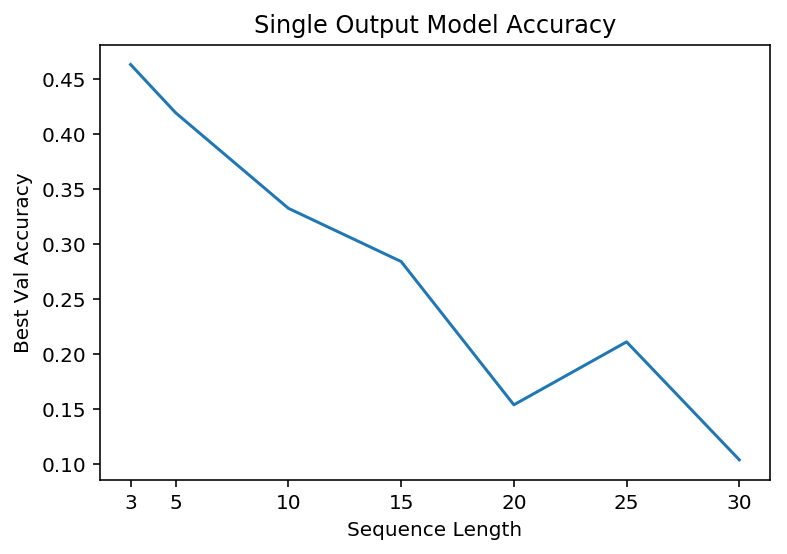

In [72]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(seq_lens)
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Best Val Accuracy')
ax.set_title('Single Output Model Accuracy')
ax.plot(seq_lens, accs);

Notice that the longer our sequence length gets, the more "confused" our model gets about what the correct next word ought to be.

## Multi-Output Fully Connected Model

Now we'll modify the previous model to be able to output an entire sequence of words as its prediction.

More specifically, we start at the beginning of our sequence of length `bptt` and predict each subsequent word. We store each of these predictions in a list, and the final prediction in the list is the same "next" word after the entire `bptt` sequence that our earlier models were predicting.

In [123]:
data = src.databunch(bs=bs, bptt=20)

In [124]:
x,y = data.one_batch()
x.shape,y.shape

(torch.Size([45, 64]), torch.Size([45, 64]))

In [105]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[1], nh).to(device=x.device)
        res = [] # store preds of each 'next' word in the sequence
        for xi in x:
            h = h + self.i_h(xi) # must avoid in-place operations
            h = self.bn(F.relu(self.h_h(h)))
            res.append(self.h_o(h))
        return torch.stack(res) # last pred is the word immediately following the bptt sequence
                                # shape is (19,64,38) (seq len x emb sz x vocab sz)

In [106]:
learn = Learner(data, Model2(), metrics=accuracy)

In [107]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.1)

epoch,train_loss,valid_loss,accuracy
1,3.609792,3.580274,0.037361
2,3.521265,3.475399,0.111850
3,3.412046,3.377761,0.187423
4,3.300155,3.290031,0.268564
5,3.197051,3.218627,0.340707
6,3.109057,3.173285,0.360737
7,3.041680,3.142778,0.364375
8,2.996122,3.119406,0.379641
9,2.965857,3.116822,0.370282
10,2.951544,3.111937,0.381884


Although this model's performance with a sequence length of 20 still isn't as good as our first base model that used a sequence length of 3, we can see its accuracy is more than twice as good (`0.153910`) as when we modified that same original base model to use a sequence length of 20.

What this means is that for longer sequence lengths, although its prediction of the first item following the sequence is usually wrong, this model does a somewhat passable job of predicting each next item inside the sequence. 

This observation motivates the final tweak that will turn our model into a standard Recurrent Neural Network -- we need to come up with a way to leverage the fact that we have a predictions for each subsequent word in the sequence. Is there a way we can make predictions for words later on, or right after, the sequence that take into account not only the immediately preceding word, but also the predictions we made for the earlier words in the sequence?

## Writing an RNN from Scratch

It turns out that we can make a prediction for the word immediately following a sequence of text that is itself influenced by our predictions for each previous word in the sequence.

This turns out to be the architecture of a standard RNN, and we will create it below. 

We will also unfortunately see a familiar problem return: there is still a ceiling on sequence length. Because of vanishing gradients, there are only so many *previous* predictions that can be used to influence our final prediction of the next word following the sequence -- too many layers and the earliest layers will no longer be able to learn. Stacking too many predictions one-on-top-of-the-other  will result in diminishing marginal returns. 

I'll demonstrate this below, as well.

In [129]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.h_h = nn.Linear(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(x.shape[1], nh).cuda()
        
    def forward(self, x):
        res = []
        h = self.h
        for xi in x:
            h = h + self.i_h(xi)
            h = F.relu(self.h_h(h))
            res.append(h)
        self.h = h.detach()     # This line is at the crux of an RNN: safely store the updated weights, 
                                # so we can use them as inputs during our next pass.
        res = torch.stack(res)
        return self.h_o(self.bn(res)) # This is other the line that makes an RNN an RNN.
                                      # Predictions are directly based on the previous
                                      # predictions for each item in the sequence.

In [130]:
seq_lens = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
accs = []

In [131]:
for l in seq_lens:
    data = src.databunch(bs=bs, bptt=l)
    learn = Learner(data, Model3(), metrics=accuracy)
    learn.fit_one_cycle(20, 3e-3)
    accs.append(learn.recorder.metrics[-1])

epoch,train_loss,valid_loss,accuracy
1,3.384314,3.329053,0.217203
2,2.692738,2.418226,0.435566
3,1.940463,2.051614,0.322427
4,1.551412,2.279587,0.335368
5,1.342217,2.974828,0.400326
6,1.207126,2.576336,0.392481
7,1.048252,2.748946,0.394725
8,0.913178,3.107788,0.412109
9,0.827491,2.868106,0.449489
10,0.717479,3.476324,0.451578


epoch,train_loss,valid_loss,accuracy
1,3.487506,3.358461,0.258663
2,3.113286,2.695935,0.413289
3,2.521313,2.064574,0.461806
4,2.045566,1.945393,0.400371
5,1.721875,2.019485,0.365254
6,1.505207,1.989697,0.455038
7,1.323425,2.032888,0.439666
8,1.166997,2.026574,0.463268
9,1.025150,2.158452,0.485817
10,0.905673,2.205943,0.496388


epoch,train_loss,valid_loss,accuracy
1,3.552092,3.534075,0.129332
2,3.328498,3.110362,0.345374
3,2.971887,2.469468,0.431776
4,2.512505,2.052486,0.464686
5,2.130290,1.923965,0.427273
6,1.834873,1.893422,0.450727
7,1.610416,1.884547,0.461324
8,1.427125,1.926240,0.458772
9,1.279448,1.882127,0.482805
10,1.157715,1.944728,0.485547


epoch,train_loss,valid_loss,accuracy
1,3.704739,3.671440,0.046720
2,3.522224,3.421575,0.152073
3,3.197498,2.875218,0.241182
4,2.774493,2.302419,0.459236
5,2.382379,2.063124,0.465579
6,2.075464,1.977657,0.461170
7,1.842956,1.966823,0.466584
8,1.663011,1.994438,0.467512
9,1.521395,1.978110,0.472792
10,1.403678,1.928083,0.482287


epoch,train_loss,valid_loss,accuracy
1,3.637246,3.613597,0.042311
2,3.536057,3.463262,0.155244
3,3.346687,3.082096,0.234916
4,3.059861,2.536467,0.348546
5,2.713410,2.145346,0.389001
6,2.390636,1.987324,0.379254
7,2.144475,1.950205,0.373066
8,1.935485,1.934915,0.375000
9,1.767849,1.920433,0.392868
10,1.634351,1.908177,0.409886


epoch,train_loss,valid_loss,accuracy
1,3.631447,3.635433,0.041847
2,3.530645,3.451391,0.165145
3,3.341304,2.993028,0.361154
4,3.063398,2.449738,0.446990
5,2.743362,2.135736,0.467667
6,2.466369,1.994069,0.465269
7,2.217784,1.945567,0.405863
8,2.019010,1.921930,0.365950
9,1.860598,1.918266,0.380801
10,1.742659,1.910207,0.383818


epoch,train_loss,valid_loss,accuracy
1,3.659373,3.586620,0.060489
2,3.579134,3.476528,0.161595
3,3.434122,3.207040,0.313815
4,3.202828,2.718486,0.414759
5,2.922848,2.323007,0.450031
6,2.638155,2.102907,0.450190
7,2.383304,2.030600,0.375774
8,2.171045,2.048056,0.334313
9,2.002704,2.065389,0.337562
10,1.867298,2.062930,0.349551


epoch,train_loss,valid_loss,accuracy
1,3.659716,3.610031,0.095761
2,3.588200,3.495002,0.128636
3,3.452177,3.193481,0.261757
4,3.244320,2.704467,0.392017
5,2.977293,2.238263,0.444771
6,2.706210,2.064119,0.425588
7,2.467570,2.025649,0.392946
8,2.265399,2.015460,0.373066
9,2.095247,2.016068,0.373298
10,1.953635,2.007854,0.371597


epoch,train_loss,valid_loss,accuracy
1,3.630456,3.617838,0.056312
2,3.566849,3.527504,0.093827
3,3.446295,3.278949,0.257271
4,3.258730,2.794125,0.339650
5,3.018355,2.345082,0.455678
6,2.770810,2.126598,0.460241
7,2.547117,2.032101,0.431080
8,2.355589,2.002342,0.391553
9,2.194571,1.987139,0.354192
10,2.060129,1.975631,0.346457


epoch,train_loss,valid_loss,accuracy
1,3.703126,3.643472,0.019028
2,3.653687,3.574833,0.046875
3,3.557509,3.398111,0.148205
4,3.406641,3.058738,0.280244
5,3.203883,2.673747,0.355121
6,2.974627,2.367667,0.380492
7,2.753072,2.180388,0.372061
8,2.556110,2.104619,0.349319
9,2.385476,2.057029,0.333308
10,2.238633,2.032740,0.331606


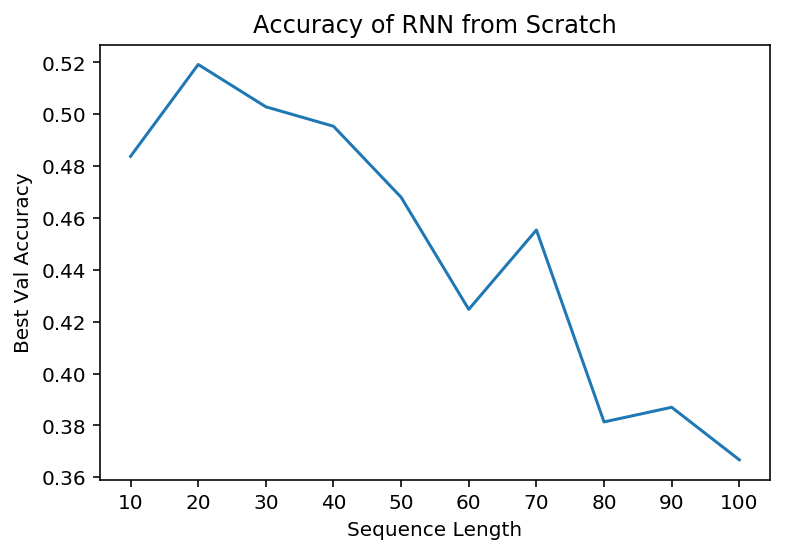

In [132]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xticks(seq_lens)
ax.set_xlabel('Sequence Length')
ax.set_ylabel('Best Val Accuracy')
ax.set_title('Accuracy of RNN from Scratch')
ax.plot(seq_lens, accs);

I had expected to see a ceiling on accuracy as I increased sequence length. Rather than diminishing marginal returns, it is clear that accuracy, itself, decreases as sequence length gets further and further above 20.

This inability to learn patterns that play out over longer durations (extended sequences) was one of the chief limitations of traditional RNNs, and was the motivator behind the invention of LSTM and GRU cells, which are both an attempt to help an RNN do a better job of remembering what happened a long time ago. 

Our final model will include a GRU cell, but first, we'll do a quick refactoring.

## Refactoring the above model using PyTorch's nn.RNN module

Before we create our final model, we'll quickly make another model that's identical to the RNN we wrote from scratch above, but this time using PyTorch's nn.RNN module. Accuracy at a sequence length of 20 should be nearly the same as that of our model above.

In [133]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.RNN(nh,nh)
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(1, x.shape[1], nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [134]:
data = src.databunch(bs=bs, bptt=20)

In [135]:
learn = Learner(data, Model4(), metrics=accuracy)

In [136]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,3.461237,3.338352,0.252630
2,3.045555,2.653579,0.459033
3,2.487665,2.172757,0.404703
4,2.029845,2.061625,0.321559
5,1.689484,2.000059,0.387454
6,1.439690,2.153950,0.376376
7,1.191181,1.918377,0.455321
8,0.990104,1.845795,0.486163
9,0.856416,1.743606,0.520833
10,0.735986,1.816331,0.521349


Sure enough our refactored model's accuracy at a sequence length of 20 after 20 epochs is `0.543880`, which is close enough to that of our model we created from scratch (`0.519183`) to pass our sanity check.

## 2-Layer GRU

Our final version of an RNN will contain the most important tweak so far: a [Gated Recurrent Unit](https://arxiv.org/abs/1412.3555), or GRU. Similar to LSTM (long-short term memory) cells, GRUs enable a recurrent neural network to maintain an ability to store and recall important patterns, even if these patterns reoccur in the dataset somewhat infrequently.

GRUs and LSTMs are actually deep neural networks in and of themselves. These networks contain layers with weights that can be trained, and the network ultimately learns to distinguish between the information that it should remember for the long term (across training iterations), and what information is likely not representative of an important pattern and can thus be discarded.

GRUs and LSTMs figure prominently in modern speech recognition and translation services, such as Amazon's Alexa and Google translate.

Michael Nguyen wrote a great [extended introduction](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) to both GRUs and LSTMs.

In our model below, we'll use an RNN that contains GRUs with 2 layers.

In [137]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv,nh)
        self.rnn = nn.GRU(nh,nh,2) # 2-layered GRU
        self.h_o = nn.Linear(nh,nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(2, bs, nh).cuda()
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        return self.h_o(self.bn(res))

In [138]:
data = src.databunch(bs=bs, bptt=20)

In [141]:
learn = Learner(data, Model5(), metrics=accuracy)

In [142]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy
1,2.960941,2.474219,0.442528
2,2.056457,1.727605,0.539217
3,1.229998,1.464411,0.686881
4,0.670897,1.414941,0.761577
5,0.343395,1.464814,0.778465
6,0.178189,1.559702,0.776973
7,0.102173,1.552531,0.783338
8,0.061186,1.550503,0.782023
9,0.039353,1.586833,0.778852
10,0.029751,1.565249,0.779858


What a difference! The addition of GRUs caused our RNN's accuracy to nearly double, reaching a maximum of `0.779858` after only ten epochs.

In this notebook we've seen that RNNs and vanilla neural networks differ by only a few lines of code. Namely, it's the ability to generate and store a prediction for every item in a sequence, and then use these previous predictions to enhance its prediction of the very next item/word/etc. that makes RNNs special.

However, as we saw in the simple example above, as far as practical application is concerned, it's really the inclusion of GRUs or LSTMs that have enabled RNNs to become the model of choice for modern language recognition tasks.